This notebook generates a PyTorch dataset from a FiftyOne dataset for training

- https://github.com/voxel51/fiftyone-examples/blob/master/examples/pytorch_detection_training.ipynb
- https://towardsdatascience.com/stop-wasting-time-with-pytorch-datasets-17cac2c22fa8
- https://voxel51.com/blog/fiftyone-tips-and-tricks-for-accelerating-computer-vision-workflows-mar-17-2023/
- https://stackoverflow.com/questions/78720028/fiftyone-dataset-with-pytorch-dataloader

In [47]:
%load_ext autoreload
%autoreload 0

import sys
import os
import os.path
import fiftyone as fo
import importlib

sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import utils.data_loader

importlib.reload(utils.data_loader)
from utils.data_loader import FiftyOneTorchDatasetCOCO, TorchToHFDatasetCOCO

import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub

try:
    dataset_v51 = load_from_hub("dbogdollumich/mcity_fisheye_v51")
except:
    dataset_v51 = fo.load_dataset("dbogdollumich/mcity_fisheye_v51")

torch_dataset = FiftyOneTorchDatasetCOCO(dataset_v51)
converter_torch_hf = TorchToHFDatasetCOCO(torch_dataset)
hf_dataset = converter_torch_hf.convert()

# Access the Hugging Face dataset directly
print(hf_dataset["train"][0])
print(hf_dataset["val"][0])

Loading dataset


Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

{'image': '/home/dbogdoll/fiftyone/huggingface/hub/dbogdollumich/mcity_fisheye_v51/data/Huron_Plymouth-Geddes_Huron_gs_Geddes_Huron1__2023-03-28__11__0_gs_Geddes_Huron1__2023-03-28__11__0__2023-03-28_11-06-01-107336.jpg', 'target': {'area': [0.00195779286368, 0.00051150339636, 0.0011067403781199999, 0.0033820519441, 0.0013978610137800002, 0.00090324489918, 0.000281334003434, 0.00615326053111, 0.00043029192374000004, 0.000234915513625, 8.399906762700001e-05, 0.00191754566928, 0.0009526452483999999, 0.0005667622415, 0.00018866580392, 0.00029278705518000003, 5.1441128595e-05, 8.138046875e-05], 'boxes': [[0.24241120000000002, 0.52306885, 0.26894880000000004, 0.59684315], [0.2269187, 0.7153157, 0.2398333, 0.7549223], [0.3742449, 0.1582507, 0.41572909999999996, 0.1849293], [0.65836125, 0.3269119, 0.7109967500000001, 0.39116609999999996], [0.7404686500000001, 0.38555629999999996, 0.7683893500000001, 0.43562169999999995], [0.7818727, 0.41576135, 0.8037932999999999, 0.45696665], [0.81200357, 0.

In [24]:
import os

import torch
import fiftyone.utils.coco as fouc
from PIL import Image
import torch
import numpy as np

tokens = {}
with open("/home/dbogdoll/mcity_data_engine/.secret", "r") as file:
    for line in file:
        key, value = line.strip().split("=")
        tokens[key] = value

os.environ["HF_TOKEN"] = tokens["HF_TOKEN"]

Resolving data files:   0%|          | 0/2746 [00:00<?, ?it/s]

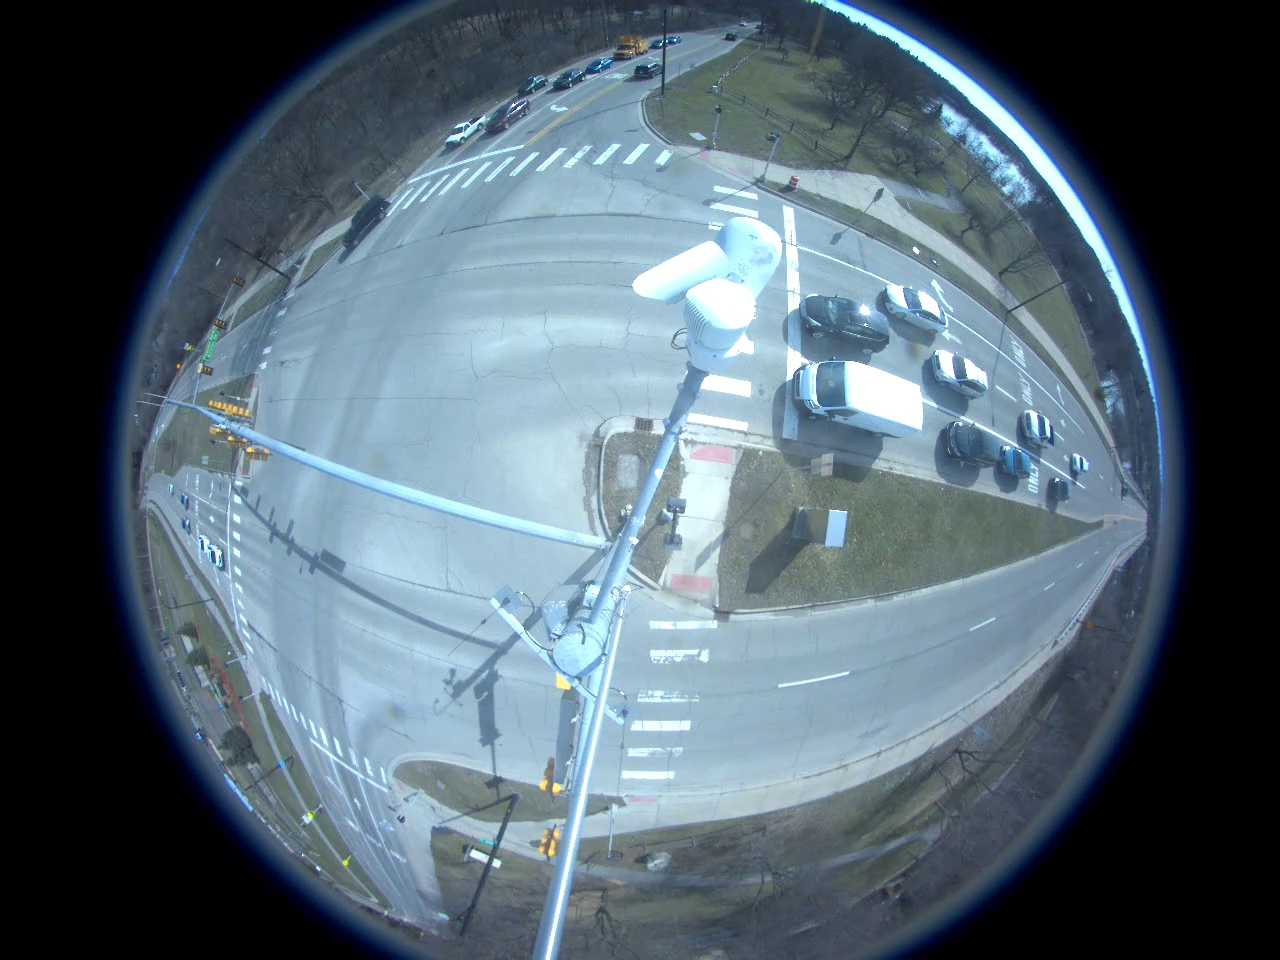

In [25]:
# Load dataset with Huggingface
from datasets import load_dataset

dataset_hf = load_dataset("dbogdollumich/mcity_fisheye_v51", split="train")
dataset_hf[0]["image"]

In [26]:
# Load dataset with Fiftyone
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub

try:
    dataset_v51 = load_from_hub("dbogdollumich/mcity_fisheye_v51")
except:
    dataset_v51 = fo.load_dataset("dbogdollumich/mcity_fisheye_v51")

Loading dataset


In [27]:
class FiftyOneTorchDataset(torch.utils.data.Dataset):
    """A class to construct a PyTorch dataset from a FiftyOne dataset.

    Args:
        fiftyone_dataset: a FiftyOne dataset or view that will be used for training or testing
        transforms (None): a list of PyTorch transforms to apply to images and targets when loading
        gt_field ("ground_truth"): the name of the field in fiftyone_dataset that contains the
            desired labels to load
        classes (None): a list of class strings that are used to define the mapping between
            class names and indices. If None, it will use all classes present in the given fiftyone_dataset.
    """

    def __init__(
        self,
        fiftyone_dataset,
        transforms=None,
        gt_field="ground_truth",
        classes=None,
    ):
        self.samples = fiftyone_dataset
        self.transforms = transforms
        self.gt_field = gt_field

        self.img_paths = self.samples.values("filepath")

        self.classes = classes
        if not self.classes:
            # Get list of distinct labels that exist in the view
            self.classes = self.samples.distinct("%s.detections.label" % gt_field)

        if self.classes[0] != "background":
            self.classes = ["background"] + self.classes

        self.labels_map_rev = {c: i for i, c in enumerate(self.classes)}

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = self.samples[img_path]
        metadata = sample.metadata
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        area = []
        iscrowd = []
        detections = sample[self.gt_field].detections
        for det in detections:
            category_id = self.labels_map_rev[det.label]
            coco_obj = fouc.COCOObject.from_label(
                det,
                metadata,
                category_id=category_id,
            )
            x, y, w, h = coco_obj.bbox
            boxes.append([x, y, x + w, y + h])
            labels.append(coco_obj.category_id)
            area.append(coco_obj.area)
            iscrowd.append(coco_obj.iscrowd)

        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["image_id"] = torch.as_tensor([idx])
        target["area"] = torch.as_tensor(area, dtype=torch.float32)
        target["iscrowd"] = torch.as_tensor(iscrowd, dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __getitems__(self, indices):
        samples = [self.__getitem__(idx) for idx in indices]
        return samples

    def __len__(self):
        return len(self.img_paths)

    def get_classes(self):
        return self.classes

    def get_splits(self):
        splits = set()
        for sample in self.samples.iter_samples():
            split = sample.tags[0]  # Assuming the split is the first tag
            splits.add(split)
        return splits

In [39]:
torch_dataset = FiftyOneTorchDataset(dataset_v51)
print(torch_dataset)
sample = torch_dataset[0]
print(sample)

(<PIL.Image.Image image mode=RGB size=1280x960 at 0x7484DB5903B0>, {'boxes': tensor([[ 310.2863,  502.1461,  344.2545,  572.9694],
        [ 290.4559,  686.7031,  306.9866,  724.7254],
        [ 479.0335,  151.9207,  532.1332,  177.5321],
        [ 842.7024,  313.8354,  910.0759,  375.5195],
        [ 947.7999,  370.1340,  983.5384,  418.1968],
        [1000.7971,  399.1309, 1028.8555,  438.6880],
        [1039.3646,  433.5495, 1051.3875,  462.3033],
        [ 809.7269,  376.7461,  908.1713,  453.5522],
        [1026.5225,  465.4791, 1043.9543,  495.8112],
        [1068.4625,  480.8181, 1079.3109,  507.4270],
        [1086.8002,  498.3201, 1093.8667,  512.9266],
        [ 887.5490,  286.3886,  936.3384,  334.6834],
        [ 980.5850,  342.9136, 1007.3549,  386.6422],
        [1024.4320,  379.4767, 1044.4371,  414.2897],
        [ 206.0851,  507.7565,  216.9319,  529.1299],
        [ 191.1959,  495.6425,  203.7891,  524.2116],
        [1099.3956,  498.6952, 1103.7942,  513.0661],
     

In [41]:
# Torch dataset to Huggingface dataset

from datasets import Dataset, NamedSplit


def gen(dataset, split_name):
    for idx in range(len(dataset)):
        img_path = dataset.img_paths[idx]
        sample = dataset.samples[img_path]
        split = sample.tags[0]
        if split != split_name:
            continue
        metadata = sample.metadata

        boxes = []
        labels = []
        area = []
        iscrowd = []
        detections = sample[dataset.gt_field].detections
        for det in detections:
            category_id = dataset.labels_map_rev[det.label]
            coco_obj = fouc.COCOObject.from_label(
                det,
                metadata,
                category_id=category_id,
            )
            x, y, w, h = coco_obj.bbox
            boxes.append([x, y, x + w, y + h])
            labels.append(coco_obj.category_id)
            area.append(coco_obj.area)
            iscrowd.append(coco_obj.iscrowd)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": idx,
            "area": area,
            "iscrowd": iscrowd,
        }

        yield {"image": img_path, "target": target, "split": split}


# Function to create HuggingFace datasets for each split
def create_hf_dataset(torch_dataset):
    splits = torch_dataset.get_splits()
    hf_datasets = {}
    for split in splits:
        hf_datasets[split] = Dataset.from_generator(
            lambda: gen(torch_dataset, split), split=NamedSplit(split)
        )
    return hf_datasets


# Create the HuggingFace datasets
hf_dataset = create_hf_dataset(torch_dataset)

print(hf_dataset["train"][0])
print(hf_dataset["val"][0])

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

{'image': '/home/dbogdoll/fiftyone/huggingface/hub/dbogdollumich/mcity_fisheye_v51/data/Huron_Plymouth-Geddes_Huron_gs_Geddes_Huron1__2023-03-28__11__0_gs_Geddes_Huron1__2023-03-28__11__0__2023-03-28_11-06-01-107336.jpg', 'target': {'area': [2405.735870889984, 628.535373447168, 1359.962576633856, 4155.86542891008, 1717.691613732864, 1109.907332112384, 345.7032234196992, 7561.126540627967, 528.742715891712, 288.66418314239996, 103.21805430005762, 2356.280118411264, 1170.61048123392, 696.4374423552, 231.832539856896, 359.7767334051841, 63.210858817536, 100.00031999999999], 'boxes': [[310.286336, 502.14609600000006, 344.254464, 572.9694240000001], [290.455936, 686.703072, 306.986624, 724.725408], [479.03347199999996, 151.920672, 532.133248, 177.532128], [842.7024, 313.835424, 910.07584, 375.519456], [947.799872, 370.13404799999995, 983.538368, 418.196832], [1000.797056, 399.13089599999995, 1028.855424, 438.687984], [1039.3645696, 433.549488, 1051.3874304, 462.303312], [809.726912, 376.746